# GNN for Graph Classification

## Installing Dependencies

In [ ]:
!python -c "import torch; print(torch.__version__)"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-geometric

## Importing Dependencies

In [3]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.utils.convert import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear

## Defining the GNN Model

In [4]:
class EnzymeNet(torch.nn.Module):
    def __init__(self):
        super(EnzymeNet, self).__init__()
        self.num_gcns1 = 5
        self.out_gcns1 = 3
        self.gcns1 = torch.nn.ModuleList()
        for _ in range(self.num_gcns1):
            self.gcns1.append(GCNConv(21, self.out_gcns1))

        self.num_gcns2 = 5
        self.mid_gcns2 = 8
        self.out_gcns2 = 3
        self.gcns2 = torch.nn.ModuleList()
        for _ in range(self.num_gcns2):
            self.gcns2.append(GCNConv(21, self.mid_gcns2))
            self.gcns2.append(GCNConv(self.mid_gcns2, self.out_gcns2))

        self.layer51 = Linear(self.num_gcns1 * self.out_gcns1, 7)
        self.layer52 = Linear(self.num_gcns2 * self.out_gcns2, 7)
        self.layer6 = Linear(14, 7)
        # self.layer7 = Linear(20,7)

    def forward(self, data):
        batch_size = max(data.batch)+1
        x, edge_index = data.x, data.edge_index
        t1 = []
        for gcn in self.gcns1:
            u = gcn(x, edge_index)
            u = F.relu(u)
            v =[]
            for i in range(batch_size):
                idx = data.batch == i
                v.append(torch.divide(torch.sum(u[idx],dim=0),sum(idx)))
            t1.append(torch.cat(v).view(-1,self.out_gcns1))
        t2 = []
        for index , gcn in enumerate(self.gcns2):
            if index % 2 == 0:
                continue
            u = self.gcns2[index-1](x, edge_index)
            u = F.relu(u)
            u = self.gcns2[index](u, edge_index)
            u = F.relu(u)
            v =[]
            for i in range(batch_size):
                idx = data.batch == i
                v.append(torch.divide(torch.sum(u[idx],dim=0),sum(idx)))
            t2.append(torch.cat(v).view(-1,self.out_gcns1))
        x1 = torch.cat(t1).view(-1,self.out_gcns1*self.num_gcns1)
        x2 = torch.cat(t2).view(-1,self.out_gcns2*self.num_gcns2)
        x1 = self.layer51(x1)
        x1 = F.relu(x1)
        x2 = self.layer52(x2)
        x2 = F.relu(x2)
        x = torch.cat([x1,x2]).view(-1,14)
        x = self.layer6(x)
        x = F.relu(x)
        # x = self.layer7(x)
        # x = F.relu(x)
        return F.log_softmax(x,dim=0)

## Importing ENZYMES Dataset

In [ ]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True).shuffle()
datasize = len(dataset)
train_set = dataset[:int(datasize*.6)]
val_set = dataset[int(datasize*.6):int(datasize*.8)]
test_set = dataset[int(datasize*.8):]

## Train the GNN

In [6]:
device = torch.device('cuda')
batch_size = 32
model = EnzymeNet().to(device)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=5e-4)
epochs=20
train_acc =[]
val_acc=[]
for epoch in range(epochs):
    model.train()
    acc = 0 
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.nll_loss(out,batch.y)
        loss.backward()
        optimizer.step()
        _, pred = out.max(dim=1)
        acc += int(pred.eq(batch.y).sum().item())
    train_acc.append(acc/len(train_set))
    
    model.eval()
    acc = 0
    for batch in test_loader:
        batch.to(device)
        out = model(batch)
        _, pred = out.max(dim=1)
        acc += int(pred.eq(batch.y).sum().item())
    val_acc.append(acc/len(val_set))

    print(f'epoch [{epoch}]\t train acc {train_acc[-1]}\t val acc {val_acc[-1]}')

epoch [0]	 train acc 0.15	 val acc 0.15
epoch [1]	 train acc 0.1527777777777778	 val acc 0.16666666666666666
epoch [2]	 train acc 0.16111111111111112	 val acc 0.14166666666666666
epoch [3]	 train acc 0.17777777777777778	 val acc 0.10833333333333334
epoch [4]	 train acc 0.1527777777777778	 val acc 0.13333333333333333
epoch [5]	 train acc 0.15555555555555556	 val acc 0.125
epoch [6]	 train acc 0.15555555555555556	 val acc 0.175
epoch [7]	 train acc 0.1527777777777778	 val acc 0.19166666666666668
epoch [8]	 train acc 0.12777777777777777	 val acc 0.13333333333333333
epoch [9]	 train acc 0.14166666666666666	 val acc 0.125
epoch [10]	 train acc 0.175	 val acc 0.16666666666666666
epoch [11]	 train acc 0.16666666666666666	 val acc 0.13333333333333333
epoch [12]	 train acc 0.1527777777777778	 val acc 0.14166666666666666
epoch [13]	 train acc 0.14166666666666666	 val acc 0.16666666666666666
epoch [14]	 train acc 0.1638888888888889	 val acc 0.13333333333333333
epoch [15]	 train acc 0.169444444444

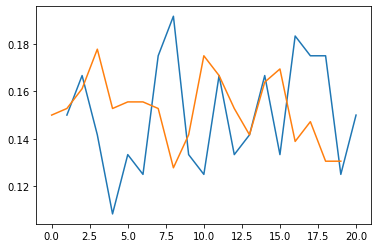

In [7]:
plt.plot(range(1,epochs+1),val_acc,train_acc)
plt.show()